<a href="https://colab.research.google.com/github/rigonzal/ANN/blob/master/Approach3/Pregunta_2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-395 Redes Neuronales Artificiales II-2018

## Tarea 3- Redes Recurrentes, Autoencoders y sus aplicaciones


21/12/2018

* Rodrigo González Smith 201303026-2
* Ignacio Valenzuela Albornoz 2014073055-1

In [0]:
from keras.datasets import mnist
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

Necesario para guardar modelos y pesos en Drive usando Colab:

In [0]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
from googleapiclient.http import MediaFileUpload


In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32')/255
n_train = len(x_train)
#5000 imágenes de validación
x_val = x_train[0:5000]
y_val = y_train[0:5000]
x_train = x_train[5001:]
y_train = y_train[5001:]

## 2.1 Reducción de dimensionalidad

### 2.1.a AE básico

Ahora vamos a reducir la dimensionaldiad de las imagenes cargasdas por medio de un *autoencoder* básico.

In [0]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
dims = [2,8,32,64]

Procedemos a entrenar con las distintas dimensiones, donde posteriormente analizaremos los errores obtenidos y nos quedaremos con el que presente los mejores resultados. Tiene sentido ocupar como función de perdida a *binary cross entropy* dado que los varios output de la capa de salida, serán la reconstrucción de la imagen la cual esta normalizada, es decir ocurre que $x_i \in [0,1]$. Así el error binario se medirá para cada nodo de salida.

In [0]:
input_img = Input(shape=(784,))
autoencoder_1_a_list = list()
history_1_a_list = list()
for i in dims:
  encoded_1_a = Dense(i, activation='sigmoid')(input_img)
  decoded_1_a = Dense(784, activation='sigmoid')(encoded_1_a)
  autoencoder_1_a = Model(input=input_img, output=decoded_1_a)
  encoder_1_a = Model(input=input_img, output=encoded_1_a)
  encoded_input_1_a = Input(shape=(i,))
  decoder_layer_1_a = autoencoder_1_a.layers[-1]
  decoder_1_a = Model(inputs=encoded_input_1_a, outputs=decoder_layer_1_a(encoded_input_1_a))
  autoencoder_1_a_list.append(autoencoder_1_a)
  autoencoder_1_a.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
  history_1_a = autoencoder_1_a.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
  history_1_a_list.append(history_1_a)
  autoencoder_1_a.save('basic_autoencoder_768x'+str(i)+'.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


Train on 54999 samples, validate on 5000 samples
Epoch 1/50
54999/54999 [==============================] - 8s 149us/step - loss: 0.4551 - acc: 0.7912 - val_loss: 0.3473 - val_acc: 0.8044
Epoch 2/50
54999/54999 [==============================] - 8s 147us/step - loss: 0.3195 - acc: 0.8043 - val_loss: 0.3016 - val_acc: 0.8046
Epoch 3/50
54999/54999 [==============================] - 8s 146us/step - loss: 0.2932 - acc: 0.8043 - val_loss: 0.2868 - val_acc: 0.8046
Epoch 4/50
54999/54999 [==============================] - 8s 146us/step - loss: 0.2829 - acc: 0.8043 - val_loss: 0.2797 - val_acc: 0.8046
Epoch 5/50
54999/54999 [==============================] - 8s 147us/step - loss: 0.2776 - acc: 0.8043 - val_loss: 0.2757 - val_acc: 0.8046
Epoch 6/50
54999/54999 [==============================] - 8s 148us/step - loss: 0.2744 - acc: 0.8043 - val_loss: 0.2732 - val_acc: 0.8046
Epoch 7/50
54999/54999 [==============================] - 8s 147us/step - loss: 0.2723 - acc: 0.8044 - val_loss: 0.2714 - v

Graficamos los errores para cada caso,  notamos que usamos SGD como optimizador para el entrenamiento.

In [0]:
def get_metrics_lists(history):
  loss_train,loss_val,acc_train,acc_val = list(),list(),list(),list()
  losses = [[] for i in range(2)]
  accs = [[] for i in range(2)]
  loss_train,loss_val,acc_train,acc_val = history.history['loss'],history.history['val_loss'], history.history['acc'],history.history['val_acc']
  losses[0] = loss_train
  losses[1] = loss_val
  accs[0] = acc_train
  accs[1] = acc_val
  return losses,accs

def triple_plot(losses, accs,title):
  plt.figure(num=None, figsize=(18, 4), dpi=80, facecolor='w', edgecolor='k')
  plt.subplot(1,2,1)
  plt.plot(losses[0])
  plt.plot(losses[1])
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.subplot(1,2,2)
  plt.plot(accs[0])
  plt.plot(accs[1])
  plt.title(title.replace("Loss", "Accuracy"))
  plt.xlabel('Epoch')
  plt.ylabel('Acc')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()
 

In [0]:
for i in range(len(history_1_a_list)):
  losses,accs = get_metrics_lists(history_1_a_list[i])
  triple_plot(losses,accs,'Model Loss - '+str(dims[i])+' DIM')

In [21]:
print("Porcentajes de compresión por dimensión")
for d in dims:
  print("Para una dimensión: "+ str(d) + " es " + str(round((1-d/784)*100,2)) + "%")

Porcentajes de compresión por dimensión
Para una dimensión: 2 es 99.74%
Para una dimensión: 8 es 98.98%
Para una dimensión: 32 es 95.92%
Para una dimensión: 64 es 91.84%


Ahora que sabemos con dimensión cual se obtiene un mejor Loss, probamos cambiando la función de activación ReLU para el *encoder*:

In [22]:
input_img = Input(shape=(784,))
encoded_1_a_2 = Dense(64, activation='relu')(input_img)
decoded_1_a_2 = Dense(784, activation='sigmoid')(encoded_1_a_2)
autoencoder_1_a_2 = Model(input=input_img, output=decoded_1_a_2)
encoder_1_a_2 = Model(input=input_img, output=encoded_1_a_2)
encoded_input_1_a_2 = Input(shape=(64,))
decoder_layer_1_a_2 = autoencoder_1_a_2.layers[-1]
decoder_1_a_2 = Model(inputs=encoded_input_1_a_2, outputs=decoder_layer_1_a_2(encoded_input_1_a_2))
autoencoder_1_a_2.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy',metrics=['accuracy'])
history_1_a_2 = autoencoder_1_a_2.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val) ,shuffle=True,)
autoencoder_1_a_2.save('basic_autoencoder_2_768x64.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


Train on 54999 samples, validate on 5000 samples
Epoch 1/50
54999/54999 [==============================] - 8s 138us/step - loss: 0.2274 - acc: 0.7945 - val_loss: 0.1709 - val_acc: 0.8038
Epoch 2/50
54999/54999 [==============================] - 7s 136us/step - loss: 0.1542 - acc: 0.8068 - val_loss: 0.1385 - val_acc: 0.8092
Epoch 3/50
54999/54999 [==============================] - 7s 135us/step - loss: 0.1295 - acc: 0.8105 - val_loss: 0.1196 - val_acc: 0.8120
Epoch 4/50
54999/54999 [==============================] - 8s 137us/step - loss: 0.1135 - acc: 0.8126 - val_loss: 0.1071 - val_acc: 0.8133
Epoch 5/50
54999/54999 [==============================] - 7s 135us/step - loss: 0.1034 - acc: 0.8136 - val_loss: 0.0996 - val_acc: 0.8140
Epoch 6/50
54999/54999 [==============================] - 8s 137us/step - loss: 0.0973 - acc: 0.8141 - val_loss: 0.0949 - val_acc: 0.8143
Epoch 7/50
54999/54999 [==============================] - 7s 136us/step - loss: 0.0933 - acc: 0.8143 - val_loss: 0.0917 - v

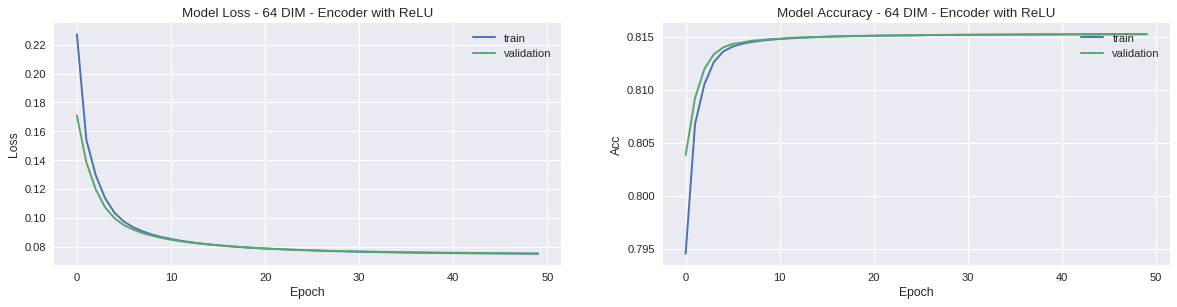

In [65]:
losses,accs = get_metrics_lists(history_1_a_2)
triple_plot(losses,accs,'Model Loss - 64 DIM - Encoder with ReLU')

Por úiltimo utilizar la función de activación ReLU en el decoder para corroborar el porque no es adecuado. Nuestra creencia es que al ser lineal no puede lograr volver a una representación adecuada de los daots

In [0]:
encoded_1_a_3 = Dense(64, activation='sigmoid')(input_img)
decoded_1_a_3 = Dense(784, activation='relu')(encoded_1_a_3)
autoencoder_1_a_3 = Model(input=input_img, output=decoded_1_a_3)
encoder_1_a_3 = Model(input=input_img, output=encoded_1_a_3)
encoded_input_1_a_3 = Input(shape=(64,))
decoder_layer_1_a_3 = autoencoder_1_a_3.layers[-1]
decoder_1_a_3 = Model(inputs=encoded_input_1_a_3, outputs=decoder_layer_1_a_3(encoded_input_1_a_3))
autoencoder_1_a_3.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history_1_a_3 = autoencoder_1_a_3.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
autoencoder_1_a_3.save('basic_autoencoder_3_768x32.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


Train on 54999 samples, validate on 5000 samples
Epoch 1/50
54999/54999 [==============================] - 9s 155us/step - loss: 1.7378 - acc: 0.7349 - val_loss: 2.5890 - val_acc: 0.7053
Epoch 2/50
54999/54999 [==============================] - 8s 151us/step - loss: 2.9467 - acc: 0.6810 - val_loss: 3.2578 - val_acc: 0.6635
Epoch 3/50
54999/54999 [==============================] - 8s 151us/step - loss: 3.5993 - acc: 0.6474 - val_loss: 3.9576 - val_acc: 0.6312
Epoch 4/50
54999/54999 [==============================] - 9s 165us/step - loss: 4.2393 - acc: 0.6177 - val_loss: 4.4136 - val_acc: 0.6102
Epoch 5/50
54999/54999 [==============================] - 9s 158us/step - loss: 4.5502 - acc: 0.6061 - val_loss: 4.5927 - val_acc: 0.6051
Epoch 6/50
54999/54999 [==============================] - 8s 145us/step - loss: 4.6952 - acc: 0.6001 - val_loss: 4.8187 - val_acc: 0.5938
Epoch 7/50
54999/54999 [==============================] - 8s 143us/step - loss: 4.8602 - acc: 0.5914 - val_loss: 4.9591 - v

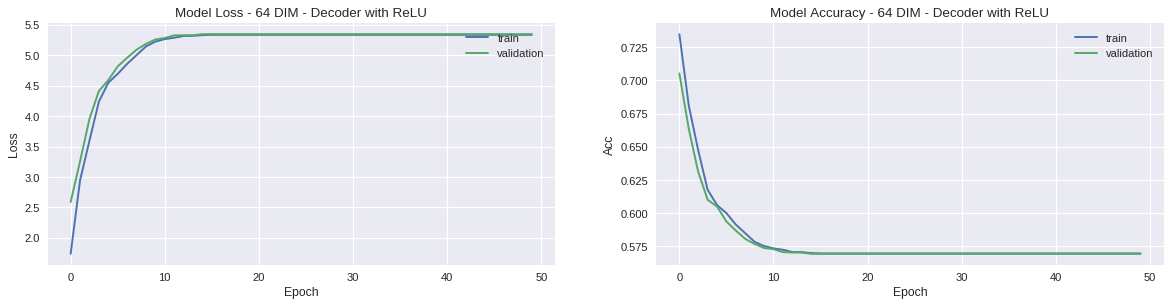

In [0]:
losses,accs = get_metrics_lists(history_1_a_3)
triple_plot(losses,accs,'Model Loss - 64 DIM - Decoder with ReLU')

### 2.1.b

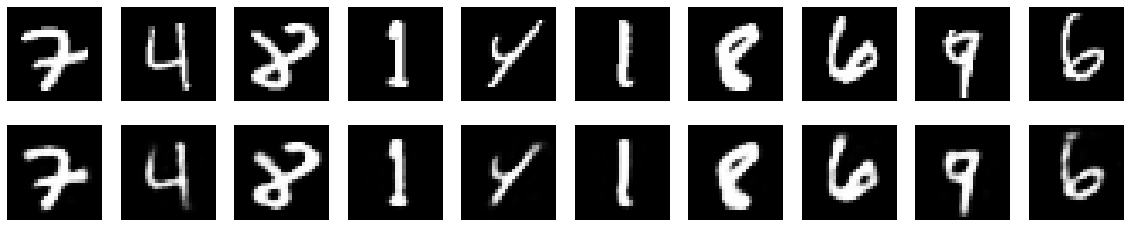

In [66]:

#autoencoder = load_model('basic_autoencoder_768x32.h5')
encoded_test_1_b = encoder_1_a_2.predict(x_test)
decoded_test_1_b = decoder_1_a_2.predict(encoded_test_1_b)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test_1_b[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 2.1.c 

In [0]:
pca_1_c = PCA(n_components=32)
pca_1_c.fit(x_train)
pca_train_1_c = pca_1_c.transform(x_train)
pca_test_1_c = pca_1_c.transform(x_test)
...#AUTOENCODER
encoded_train_1_c = encoder_1_a_2.predict(x_train)
encoded_test_1_c = encoder_1_a_2.predict(x_test)
...#CLASIFICATION
clf_1_c = KNeighborsClassifier(10)
clf_1_c.fit(pca_train_1_c, y_train)
print('Classification Accuracy PCA %.2f ' + str(clf_1_c.score(pca_test_1_c,y_test))) 
clf_1_c = KNeighborsClassifier(10)
clf_1_c.fit(encoded_train_1_c, y_train)
print('Classification Accuracy %.2f ' + str(clf_1_c.score(encoded_test_1_c,y_test)))

ValueError: ignored

{'loss': [0.4558386428544438,
  0.3195903637030595,
  0.2932278436074142,
  0.2829623430721864,
  0.2776404959966613,
  0.2744289670083264,
  0.27229823381498197,
  0.27078977489313644,
  0.26967026176748543,
  0.2688092311019605,
  0.26812819550162187,
  0.2675770850366379,
  0.2671225307994514,
  0.2667419145472663,
  0.2664189419693686,
  0.2661414019723236,
  0.2659009849675779,
  0.26569061021019835,
  0.26550513760235384,
  0.26534048703764196,
  0.2651933186705428,
  0.26506117293731907,
  0.26494201152200564,
  0.264833737438448,
  0.26473518954294134,
  0.26464506428285817,
  0.2645622163853317,
  0.2644862333592134,
  0.26441615672759067,
  0.2643509221792451,
  0.26429060585995295,
  0.2642343695321866,
  0.26418188471609155,
  0.26413289235379234,
  0.2640869096909075,
  0.26404391647395237,
  0.26400333934106485,
  0.26396523122158994,
  0.2639291274747852,
  0.2638952729604416,
  0.2638630445266772,
  0.26383244505840925,
  0.2638035591432109,
  0.2637761873126791,
  0.26